## INTRODUCTION ##

This project implements a CycleGAN model using TensorFlow and Keras to transform photos into Monet - style paintings. By leveraging 2 generators and 2 discriminators, the model learns to translate images between the two domains while maintaining image consistency through cycle and identity loss. The goal is to apply Monet's artistic style to real-world photos and generate the output images in a compressed zip file for submission.

The inputs are 2 files, the first has 300 Monet paintings and the second has 7038 real photos to be turned into Monet paintings. Both files are in tfrec format

In [32]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import zipfile


In [33]:
AUTOTUNE = tf.data.AUTOTUNE

In [34]:
strategy = tf.distribute.get_strategy()

## Exploratory Data Analysis ## 

### Load & Parse TFRecords ### 

TFRecords are a binary format for storing large datasets in TensorFlow. Since we have 2 TFRecord datasets, we will read and decode each one.  

The parse_tfrecord_fn function is designed to read and decode individual images from the TFRecord dataset. In this step, each image is decoded from JPEG format and normalized by scaling pixel values from the range [0,255] to [-1, 1]. This normalization helps the model train more effectively, as neural networks typically perform better when inputs have small, centered values. The function also resizes each image to 256x256, which standardizes the input size for the model, ensuring consistent training.

In [35]:
monet_tfrec_path = []
photo_tfrec_path = []

for dirname, _, filenames in os.walk('../input/gan-getting-started/monet_tfrec'):
    for filename in filenames:
         monet_tfrec_path.append(os.path.join(dirname, filename))
            
for dirname, _, filenames in os.walk('../input/gan-getting-started/photo_tfrec'):
    for filename in filenames:
         photo_tfrec_path.append(os.path.join(dirname, filename))

monet_tfrec_path

['../input/gan-getting-started/monet_tfrec/monet12-60.tfrec',
 '../input/gan-getting-started/monet_tfrec/monet16-60.tfrec',
 '../input/gan-getting-started/monet_tfrec/monet08-60.tfrec',
 '../input/gan-getting-started/monet_tfrec/monet04-60.tfrec',
 '../input/gan-getting-started/monet_tfrec/monet00-60.tfrec']

In [36]:
def parse_tfrecord_fn(eg):
    feature_Description = {
        'image':tf.io.FixedLenFeature([],tf.string),
        
    }
    
    parsed_eg = tf.io.parse_single_example(eg, feature_Description)
    image = tf.io.decode_jpeg(parsed_eg['image'], channels=3)
    image = tf.cast(image, tf.float32)/127.5 - 1.0
    image = tf.image.resize(image, (256,256))
    return image

In [37]:
def create_dataset (file_path):
    dataset = tf.data.Dataset.from_tensor_slices(file_path)
    dataset = dataset.flat_map(lambda x:tf.data.TFRecordDataset(x).map(parse_tfrecord_fn,
                                                                      num_parallel_calls=tf.data.experimental.AUTOTUNE))
    #dataset = tf.data.TFRecordDataset(file_path)
    return dataset

In [38]:
monet_dataset = create_dataset(monet_tfrec_path)
photo_dataset = create_dataset(photo_tfrec_path)

In [39]:
monet_dataset = monet_dataset.shuffle(buffer_size=len(monet_tfrec_path)).batch(1).prefetch(tf.data.experimental.AUTOTUNE)
photo_dataset = photo_dataset.shuffle(buffer_size=len(photo_tfrec_path)).batch(1).prefetch(tf.data.experimental.AUTOTUNE)

Checking how many images were loaded into each dataset.

In [9]:
print(sum(1 for _ in monet_dataset))
print(sum(1 for _ in photo_dataset))

300
7038


### Comparing Monet Paintings and Photos  ###

To ensure that the images are loaded correctly, we will visualize a few samples from both the Monet datset and the Photo dataset.

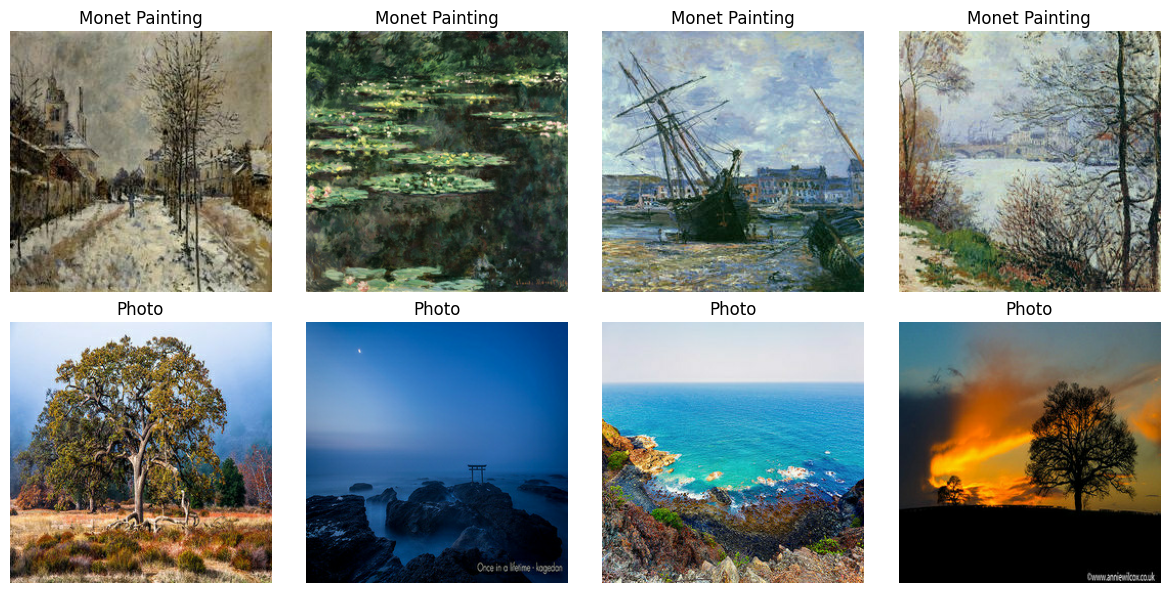

In [40]:
def plot_sample_images(monet_dataset, photo_dataset, num_img = 4):
    plt.figure(figsize=(12,6))
    
    monet_images = list(monet_dataset.take(num_img))
    photo_images = list(photo_dataset.take(num_img))
    
    for i in range(num_img):
        plt.subplot(2, num_img, i+1)
        plt.imshow(monet_images[i][0].numpy() * 0.5+0.5)
        plt.axis('off')
        plt.title('Monet Painting')
        
        plt.subplot(2, num_img, i+num_img+1)
        plt.imshow(photo_images[i][0].numpy() * 0.5 + 0.5)
        plt.axis('off')
        plt.title('Photo')
        
    plt.tight_layout()
    plt.show()

plot_sample_images(monet_dataset,photo_dataset,4)
    

### Image Augmentation  ###  

Data augmentation is a crucial step in EDA that artificially increases the diversity of the dataset by applying random transformations such as flipping, rotation, or cropping. In this project, data augmentation is used to make the model more robust by introducing variability in the training images. Since GAN models rely heavily on learning image features, augmentation helps the model generalize better and reduce overfitting. Below are the data augmentation steps performed in this project.

* Random Flipping
* Random Rotation
* Random Brightness
* Random Cropping
* Color Jittering

In [43]:
data_augmentation = tf.keras.Sequential([layers.RandomFlip ("horizontal_and_vertical"),
                                         layers.RandomRotation(0.2),
                                         layers.RandomZoom(0.2),
                                         layers.RandomContrast(0.2),
                                         #layers.RandomBrightness(0.0001),
                                        
])

def augment_images(dataset):
    return dataset.map(lambda x: (data_augmentation(x, training=True)))

augmented_monet_dataset = augment_images(monet_dataset)
augmented_photo_dataset = augment_images(photo_dataset)

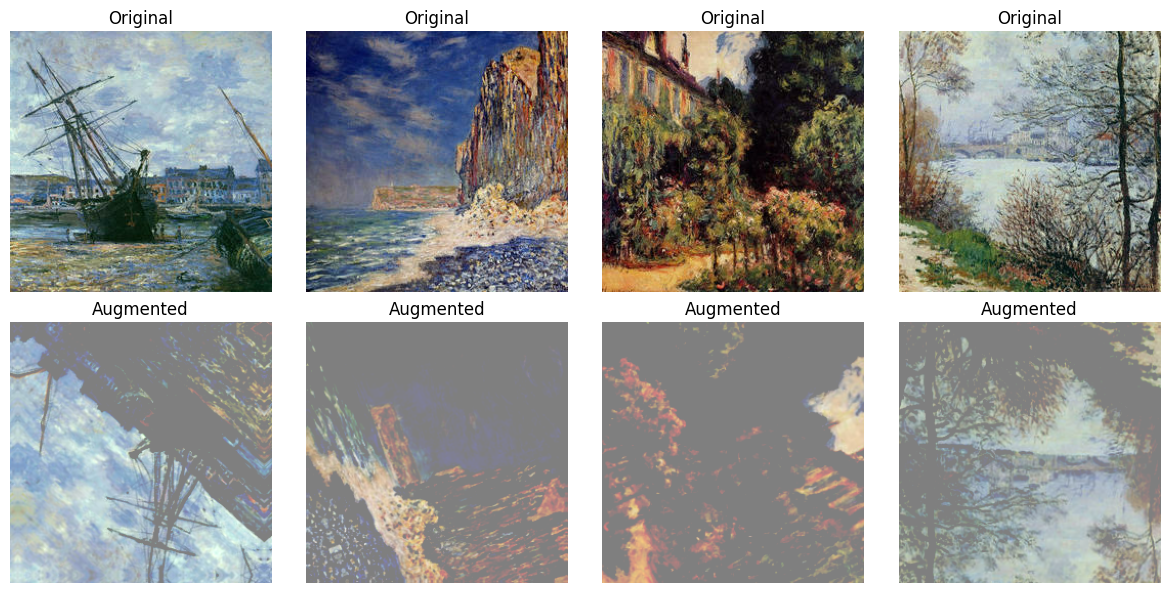

In [44]:
def visualize_augmented_images(dataset, num_img = 4):
    plt.figure(figsize=(12,6))
    for i, img in enumerate(dataset.take(num_img)):
        raw_img = img[0].numpy()
        raw_img = tf.image.convert_image_dtype(raw_img, dtype=tf.float32)
        aug_img = data_augmentation(tf.expand_dims(raw_img, axis=0), training=True)
        aug_img = aug_img[0].numpy()
        
        plt.subplot(2, num_img, i+1)
        plt.imshow(raw_img * 0.5+0.5)
        plt.axis('off')
        plt.title('Original')
        
        plt.subplot(2, num_img, i+num_img +1)
        plt.imshow(aug_img * 0.5+0.5)
        plt.axis('off')
        plt.title('Augmented')
    
    plt.tight_layout()
    plt.show
    
visualize_augmented_images(monet_dataset, num_img=4)

## Model Building ##  

### Residual Learning ###

It consists of two convolutional layers with a ReLU activation in between, followed by batch normalization. The input is passed through these layers and then added back to the original input, creating a "skip connection." This skip connection helps the model avoid the vanishing gradient problem during training, making it easier for the network to learn transformations without losing important features from the original image. Residual blocks allow the model to focus on learning differences (or residuals) rather than entirely new representations, leading to more efficient and stable training.

In [45]:
def residual_block(x):
    res = layers.Conv2D(256, (3,3), padding = 'same')(x)
    res = layers.BatchNormalization()(res)
    res = layers.ReLU()(res)
    res = layers.Conv2D(256, (3,3), padding='same')(res)
    res = layers.BatchNormalization()(res)
    return layers.add([x, res])

### Building CycleGAN Generator and Discriminator ###  

The generator is designed to map an input image from one domain (e.g., a photo) to another domain (e.g., a Monet-style painting) by applying a series of convolutional layers. The architecture starts with a few downsampling layers to reduce the spatial dimensions, followed by a series of residual blocks, which help maintain the original content of the image while learning to apply transformations. These residual blocks ensure that the generator focuses on learning stylistic changes rather than reconstructing the entire image. After the residual layers, the model applies upsampling layers to restore the image to its original dimensions. The final layer applies a tanh activation, which outputs the generated image with pixel values in the range of [-1, 1], suitable for feeding into the model.  


The discriminator acts as a binary classifier, distinguishing between real images and the ones generated by the generator. The architecture consists of several convolutional layers, each with progressively increasing filters, which allows the model to capture fine details and patterns that differentiate real from generated images. Each convolutional layer is followed by batch normalization and a LeakyReLU activation to stabilize training and allow better gradient flow. The final layer outputs a probability score, using a sigmoid activation to indicate whether the input image is real (closer to 1) or fake (closer to 0). The goal of the discriminator is to become more adept at detecting generated images while the generator tries to fool it by producing more realistic outputs.

In [15]:
def generator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    downsample = layers.Conv2D(64, (7,7), padding='same')(inputs)
    downsample = layers.BatchNormalization()(downsample)
    downsample = layers.ReLU()(downsample)
    
    downsample = layers.Conv2D(128, (3,3), strides=2, padding='same')(downsample)
    downsample = layers.BatchNormalization()(downsample)
    downsample = layers.ReLU()(downsample)
    
    downsample = layers.Conv2D(256, (3,3), strides=2, padding='same')(downsample)
    downsample = layers.BatchNormalization()(downsample)
    downsample = layers.ReLU()(downsample)
    
    res_block = residual_block(downsample)
    for _ in range(8):
        res_block = residual_block(res_block)
    
    upsample = layers.Conv2DTranspose(128, (3,3), strides=2, padding = 'same')(res_block)
    upsample = layers.BatchNormalization()(upsample)
    upsample = layers.ReLU()(upsample)
    
    upsample = layers.Conv2DTranspose(64, (3,3), strides=2, padding = 'same')(upsample)
    upsample = layers.BatchNormalization()(upsample)
    upsample = layers.ReLU()(upsample)
        
    output = layers.Conv2D(3, (7,7), padding = 'same', activation ='tanh')(upsample)
    
    return tf.keras.Model(inputs=inputs, outputs=output)

In [16]:
def discriminator():
    
    inputs = layers.Input(shape=[256, 256, 3])
    
    downsample = layers.Conv2D(64, (4,4),strides=2, padding='same')(inputs)
    downsample = layers.LeakyReLU()(downsample)
    
    downsample = layers.Conv2D(128, (4,4),strides=2, padding='same')(downsample)
    downsample = layers.LeakyReLU()(downsample)
    
    downsample = layers.Conv2D(256, (4,4),strides=2, padding='same')(downsample)
    downsample = layers.LeakyReLU()(downsample)
    
    downsample = layers.Conv2D(512, (4,4),strides=1, padding='same')(downsample)
    downsample = layers.LeakyReLU()(downsample)
    
    output = layers.Conv2D(1,(4,4), padding='same')(downsample)
    
    return tf.keras.Model(inputs=inputs, outputs=output)



In [17]:
monet_generator = generator()
photo_generator = generator()
monet_discriminator = discriminator()
photo_discriminator = discriminator()

In [18]:
monet_generator.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ re_lu_1[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    590,080 │ re_lu_2[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    590,080 │ re_lu_3[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ re_lu_2[0][0],    │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ add[0][0]       

 Total params: 11,399,171 (43.48 MB)

 Trainable params: 11,388,675 (43.44 MB)

 Non-trainable params: 10,496 (41.00 KB)

In [19]:
monet_discriminator.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,764,737 (10.55 MB)

 Trainable params: 2,764,737 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

### Compile Models ###

In [20]:
monet_generator.compile(loss = 'binary_Crossentropy', optimizer='adam')
photo_generator.compile(loss = 'binary_Crossentropy', optimizer='adam')

In [21]:
monet_discriminator.compile(loss = 'binary_Crossentropy', optimizer=Adam(2e-4, beta_1 = 0.5))
photo_discriminator.compile(loss = 'binary_Crossentropy', optimizer=Adam(2e-4, beta_1 = 0.5))

## Model Training ##  

1. Photo to Monet, Back to Photo: First, we take a real photo, translating it to a Monet-style painting using the photo-to-Monet generator, and then passing this generated Monet-style image back through the Monet-to-photo generator to return to the original domain. This step ensures the model learns how to recreate the original photo.

2. Monet to Photo, Back to Monet: A real Monet painting is translated into a photo using the Monet-to-photo generator, and then this generated photo is translated back to a Monet-style painting using the photo-to-Monet generator. This ensures the model can maintain stylistic consistency when moving between the two domains.

3. Identity Mapping: Ensures that a photo passed through the photo generator (or a Monet painting passed through the Monet generator) remains unchanged, the model is trained on identity loss. This helps the generator avoid unnecessary alterations when it should preserve the input’s style and content.

4. Discriminator Checking Real Images: The discriminator for Monet and photo images is trained to differentiate real images from generated ones. When real images (e.g., Monet paintings) are passed through the discriminator, it should output a high score indicating that these are indeed real images.

5. Discriminator Checking Fake Images: The discriminator also evaluates fake, generated images (e.g., photos styled like Monet paintings). Its goal is to output a low score, indicating that these generated images are fake.

6. Evaluating Generator Loss: The generator loss is calculated based on how well the generator can fool the discriminator. This adversarial loss encourages the generator to produce realistic images.

7. Evaluating Cycle Consistency Loss: The total cycle consistency loss evaluates how well the model preserves the content of the image after it is translated from one domain to the other and back again. This ensures that even after a style transformation, the image retains its original structure and details.

8. Evaluating Total Generator Loss: The total generator loss is a combination of the adversarial loss (from fooling the discriminator) and the cycle consistency loss. This combined loss encourages the generator to produce both realistic and content-preserving images.

9. Evaluating Discriminator Loss: The discriminator loss is calculated based on how well it distinguishes between real and fake images. A lower discriminator loss means the discriminator is becoming better at detecting fake images, which in turn pushes the generator to improve.

10. Calculating Gradients: Gradients are calculated for both the generator and discriminator, representing the changes needed in the model’s parameters to reduce the respective losses. This gradient calculation is done through backpropagation.

11. Applying Gradients to Optimizer: Once the gradients are computed, they are applied to the model using an optimizer (e.g., Adam). This updates the weights of the generator and discriminator, improving their performance over time. The optimizer helps the model converge to a solution where the generator produces realistic images and the discriminator becomes better at classification

In [46]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Identity Mapping
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [47]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [48]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=2
)


Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 8507s 28s/step - monet_disc_loss: 0.6860 - monet_gen_loss: 8.0510 - photo_disc_loss: 0.6713 - photo_gen_loss: 8.0967
Epoch 2/2


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 8708s 29s/step - monet_disc_loss: 0.6793 - monet_gen_loss: 7.7057 - photo_disc_loss: 0.6537 - photo_gen_loss: 7.6778


## Final Output ##

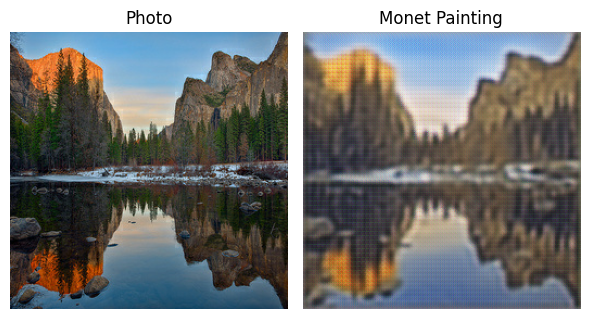

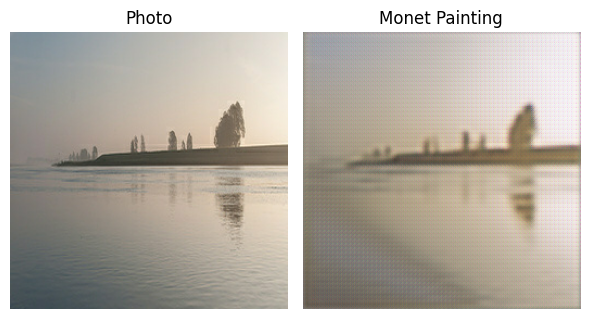

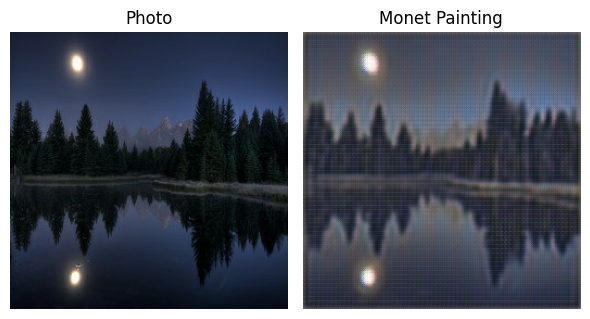

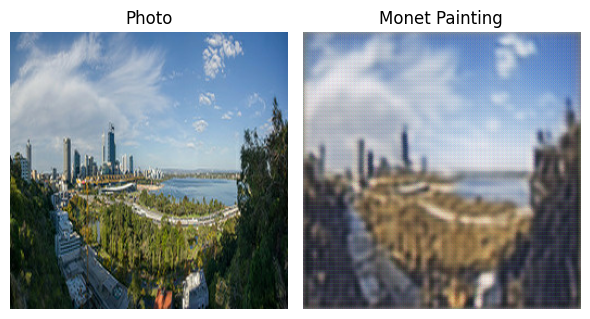

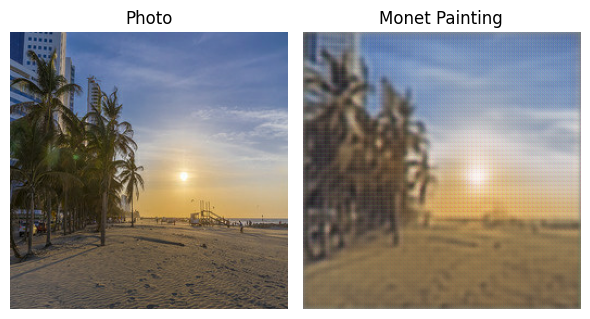

In [58]:
for i, img in enumerate(photo_dataset.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    plt.figure(figsize=(6,6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Photo")
    plt.axis('off')


    plt.subplot(1,2,2)
    plt.imshow(prediction)
    plt.title("Monet Painting")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [59]:
import PIL
! mkdir ../images
i = 1
for img in photo_dataset:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    print(f"{i} complete")
    i += 1

    
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

1 complete
2 complete
3 complete
4 complete
5 complete
6 complete
7 complete
8 complete
9 complete
10 complete
11 complete
12 complete
13 complete
14 complete
15 complete
16 complete
17 complete
18 complete
19 complete
20 complete
21 complete
22 complete
23 complete
24 complete
25 complete
26 complete
27 complete
28 complete
29 complete
30 complete
31 complete
32 complete
33 complete
34 complete
35 complete
36 complete
37 complete
38 complete
39 complete
40 complete
41 complete
42 complete
43 complete
44 complete
45 complete
46 complete
47 complete
48 complete
49 complete
50 complete
51 complete
52 complete
53 complete
54 complete
55 complete
56 complete
57 complete
58 complete
59 complete
60 complete
61 complete
62 complete
63 complete
64 complete
65 complete
66 complete
67 complete
68 complete
69 complete
70 complete
71 complete
72 complete
73 complete
74 complete
75 complete
76 complete
77 complete
78 complete
79 complete
80 complete
81 complete
82 complete
83 complete
84 complete
8

'/kaggle/working/images.zip'

## Conclusion ##  

In this project, we successfully implemented a CycleGAN model to transform photos into Monet-style paintings, gaining insights into adversarial training and cycle consistency to preserve image content. A key challenge was the high runtime due to limited GPU resources, which slowed down training and necessitated careful management of computational efficiency. Despite this, the model performs well, but future improvements could include optimizing the architecture for faster training and experimenting with more efficient hardware to reduce processing time. Enhancing model performance on higher-resolution images and further tuning could also lead to better results.